sources:

https://blog.keras.io/building-autoencoders-in-keras.html
https://github.com/PyTorchLightning/pytorch-lightning/blob/master/pl_examples/basic_examples/autoencoder.py

In [1]:
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
# %matplotlib notebook

## Data

In [3]:
from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST
from torch.utils.data import DataLoader, random_split

In [4]:
_DATASETS_PATH = 'data'

In [5]:
dataset = FashionMNIST(_DATASETS_PATH, train=True, download=True, transform=transforms.ToTensor());
mnist_test = FashionMNIST(_DATASETS_PATH, train=False, download=True, transform=transforms.ToTensor());
mnist_train, mnist_val = random_split(dataset, [55000, 5000]);

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw

Processing...


C:\Users\M\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [6]:
img, target = mnist_train[0]
print(f'image shape {img.shape}, target: {target}')

image shape torch.Size([1, 28, 28]), target: 4


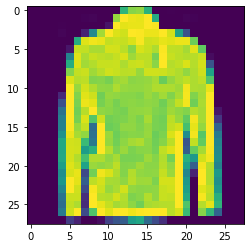

In [7]:
plt.imshow(img[0])

## Model

In [32]:
import torch
from torch import nn
# import torch.nn.functional as F

In [33]:
hidden_dim = 64
embedding_dim = 3

Fully connected encoder and decoder

In [34]:
encoder_fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, embedding_dim),
)
decoder_fc = nn.Sequential(
    nn.Linear(embedding_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, 28 * 28),
)

## Training

In [35]:
def training_step_fc(encoder, decoder, batch, criterion, device='cpu'):
    x, y = batch
    x = x.to(device)
    z = encoder(x) # latent space representation
    x_hat = decoder(z) 
    loss = criterion(x_hat, x.view((len(x), -1)))
    return loss

In [36]:
batch_size = 32

In [37]:
mnist_train_dataloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
mnist_val_dataloader = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
mnist_test_dataloader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [38]:
x, y = next(iter(mnist_train_dataloader))
print(f'x shape: {x.shape}')
print(f'target shape: {y.shape}')
print(f'target: {y}')

x shape: torch.Size([32, 1, 28, 28])
target shape: torch.Size([32])
target: tensor([1, 8, 2, 2, 3, 8, 0, 3, 0, 3, 8, 1, 5, 0, 1, 1, 3, 4, 5, 2, 5, 8, 9, 4,
        1, 1, 6, 6, 1, 9, 7, 7])


In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder_fc = encoder_fc.to(device)
decoder_fc = decoder_fc.to(device)

optimizer = torch.optim.AdamW([*encoder_fc.parameters(), *decoder_fc.parameters()], lr=1e-3)
criterion = nn.MSELoss().to(device)

In [40]:
import tqdm

In [41]:
num_epochs = 20

for i_epoch in range(num_epochs):
    for batch in tqdm.notebook.tqdm_notebook(mnist_train_dataloader, desc=f'epoch {i_epoch}'):
        # clear gradient from previous step
        optimizer.zero_grad()
        loss = training_step_fc(encoder_fc, decoder_fc, batch, criterion, device)
        
        # compute accumulated gradients
        loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        

epoch 0:   0%|          | 0/1719 [00:00<?, ?it/s]

epoch 1:   0%|          | 0/1719 [00:00<?, ?it/s]

epoch 2:   0%|          | 0/1719 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [18]:
@torch.no_grad()
def encode_image(img, encoder):
    return encoder(img.view(1, 1, -1))[0]

@torch.no_grad()    
def reconstruct_image(img, encoder, decoder):
    representation = encode_image(img, encoder)
    return decoder(representation.unsqueeze(0))[0].view(img.shape)

In [19]:
encoder_fc = encoder_fc.to('cpu')
decoder_fc = decoder_fc.to('cpu')

In [20]:
encoder_fc(img.view(1, 1, -1))[0]

tensor([-2.5042,  2.0298,  4.5560], grad_fn=<SelectBackward>)

In [21]:
img, target = mnist_test[0]
reconstruction = reconstruct_image(img, encoder_fc, decoder_fc)

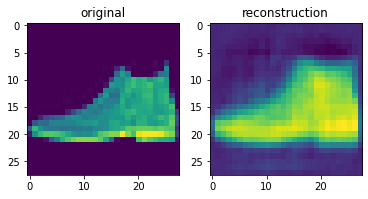

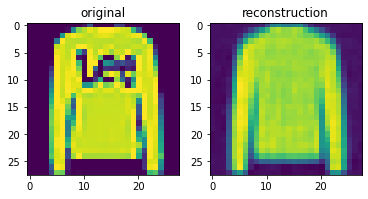

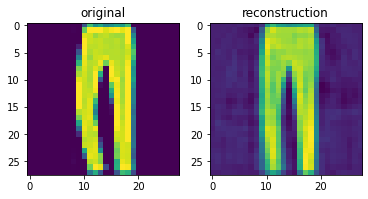

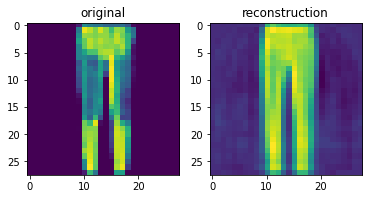

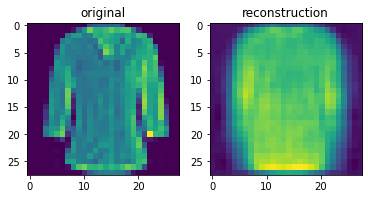

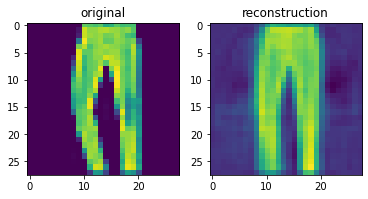

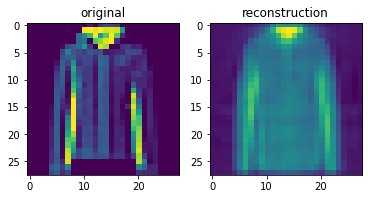

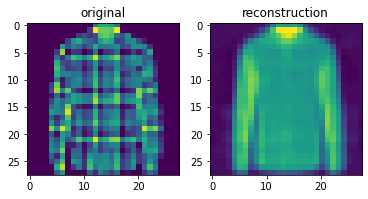

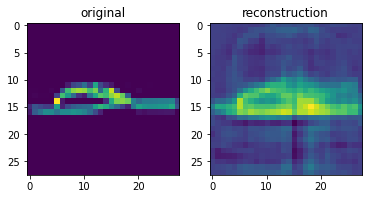

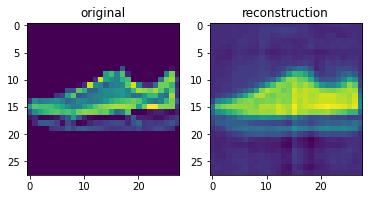

In [22]:
for i in range(10):
    img, target = mnist_test[i]
    reconstruction = reconstruct_image(img, encoder_fc, decoder_fc)
    fig, axs = plt.subplots(ncols=2)
    axs[0].imshow(img[0])
    axs[0].set_title('original')
    axs[1].imshow(reconstruction[0])
    axs[1].set_title('reconstruction')

# Autoencoder as class

In [23]:
class FCAutoencoder(nn.Module):
    def __init__(self, io_size, hidden_dim=64, latent_dim=3):
        super(FCAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(io_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, io_size),
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    @torch.no_grad()
    def encode(self, x):
        return self.encoder(x)

In [24]:
autoencoder_fc = FCAutoencoder(28*28)

# Latent space distribution

In [23]:
import numpy as np

In [24]:
representations = np.array([encode_image(x[0], encoder_fc).numpy() for x in dataset]) #

labels = np.array([x[1] for x in dataset])

In [25]:
from sklearn.manifold import TSNE

In [26]:
X_embedded = TSNE(n_components=2).fit_transform(representations)

In [29]:
%matplotlib qt
for i, label in enumerate(dataset.classes):
    X_cat = X_embedded[labels==i]
    plt.scatter(X_cat[:,0], X_cat[:,1], label=f'{label}', c=f'C{i}', alpha=0.2)
plt.legend()

In [28]:
dataset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

# Convolutional autoencoder

In [30]:
class ConvAutoencoder(nn.Module):
    """zrodlo ??"""
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode_image(self, x):
        with torch.no_grad():
            return self.encoder(x.unsqueeze(0))[0].view(1,-1)
        

In [31]:
conv_ae = ConvAutoencoder()

In [32]:
conv_ae(img.unsqueeze(0)).shape

torch.Size([1, 1, 28, 28])

In [33]:
def training_step_conv(autoencoder, batch, criterion, device='cpu'):
    x, y = batch
    x = x.to(device)
    x_hat = autoencoder(x) 
    loss = criterion(x_hat, x)
    return loss

In [34]:
optimizer = torch.optim.Adam(conv_ae.parameters(), lr=1e-3)
conv_ae.to(device);

In [35]:
device

'cuda'

In [30]:
num_epochs = 20

for i_epoch in range(num_epochs):
#     print(f'epoch {i_epoch}')
    for batch in tqdm.notebook.tqdm_notebook(mnist_train_dataloader, desc=f'epoch {i_epoch}'):
        # clear gradient from previous step
        optimizer.zero_grad()
        loss = training_step_conv(conv_ae, batch, criterion, device)
        
        # compute accumulated gradients
        loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()

epoch 0:   0%|          | 0/1719 [00:00<?, ?it/s]

NameError: name 'training_step_conv' is not defined

In [37]:
conv_ae.encoder.cpu()(img.unsqueeze(0))[0].shape

torch.Size([8, 2, 2])

# Latent space distribution

In [39]:
representations = np.array([conv_ae.encode_image(x[0]).numpy()[0] for x in dataset]) #

labels = np.array([x[1] for x in dataset])

In [43]:
X_embedded = TSNE(n_components=2).fit_transform(representations)

In [44]:
%matplotlib qt
for i, label in enumerate(np.unique(labels)):
    X_cat = X_embedded[labels==label]
    plt.scatter(X_cat[:,0], X_cat[:,1], label=f'{i}', c=f'C{i}', alpha=0.2)
plt.legend()